In [16]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
import cantera as ct
imp.reload(rmtchem)
plt.rcParams.update({'font.size': 16, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

### Example graph 

58


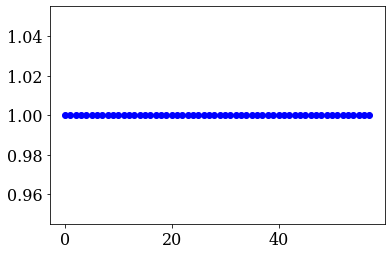

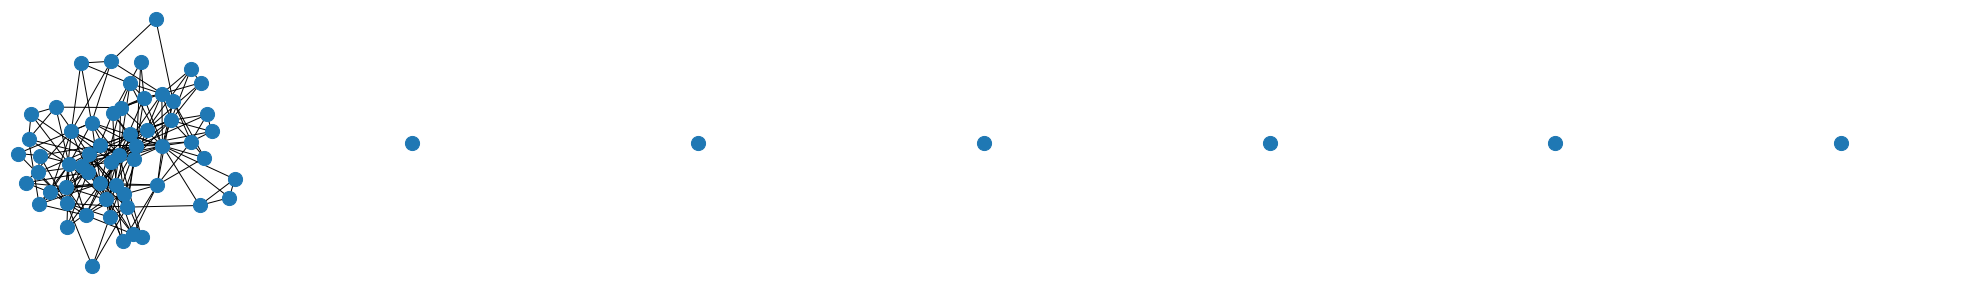

In [17]:
n=64
c=0.5
nr=int(c*n)
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2).x
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
if len(components)>1:
    fig, ax = plt.subplots(1,len(components),figsize=(5*len(components),5))
    for i in range(len(components)):
        comp=list(components)[i]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=200,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=200)

plt.savefig('plots/fig0b.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

In [21]:
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,1)

print(np.where(eta[0]>0)[0], eta[0,np.where(eta[0]>0)[0]])
print(np.where(nu[0]>0)[0],nu[0,np.where(nu[0]>0)[0]])

[23] [1.]
[17 23] [1. 2.]


### Chemical network percolation

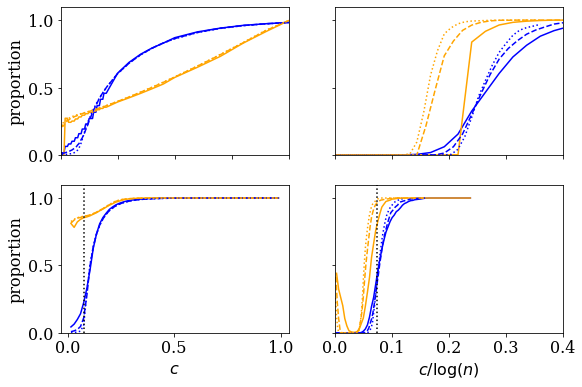

In [95]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(9,6))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
   
plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
   
plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])

plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.show()

In [40]:
0.3*np.log(100)

1.3815510557964275

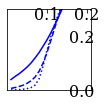

In [151]:
ns=[100,1000,10000]
ls=['-','--',':']
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.tick_params(axis="y",direction="in", right="off",pad=-22)
ax.tick_params(axis="x",direction="in",top="off", pad=-15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()

#plt.figure(figsize=(1.5,1.5))
plt.ylim(0,0.3)
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing2/'+str(n)+'/scounts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    
plt.savefig('plots/fig2inset.pdf')
plt.show()


-0.2529506225313963


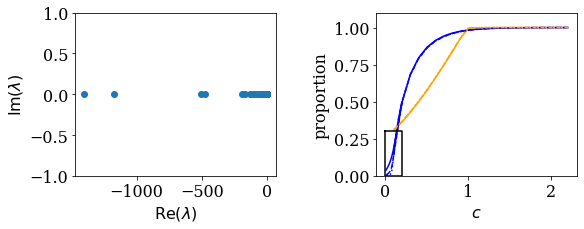

In [152]:
plt.subplots(1,2,figsize=(9,3))
plt.subplot(1,2,1)
n=50
nr=100
np.random.seed(1)
eta,nu,k,G=rmtchem.get_network(n,nr)
evals,evecs=np.linalg.eig(rmtchem.jac(np.exp(-G),eta,nu,k,np.zeros(n),np.zeros(n)))
plt.xlabel('$\mathrm{Re}(\lambda)$')
plt.ylabel('$\mathrm{Im}(\lambda)$')
plt.ylim(-1,1)
plt.scatter(x=np.real(evals),y=np.imag(evals))
print(np.max(np.real(evals)))

plt.subplot(1,2,2)
n=200
ns=[100,1000,10000]
ls=['-','--',':','-.']
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing2/'+str(n)+'/scounts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'/scounts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    

plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.subplots_adjust(wspace=0.5,hspace=0.0)

plt.savefig("plots/fig2.pdf",transparent=True)
plt.show()

### Bifurcations vs driving and connectivity

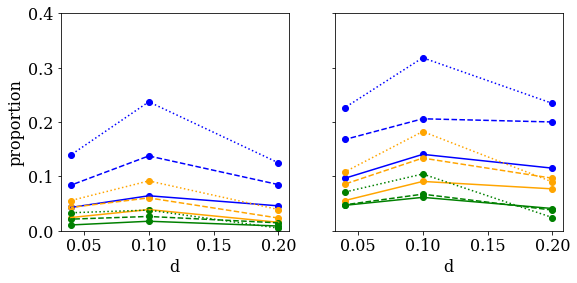

In [3]:
ns=[50,100,200]
ls=["-","--",":"]
cols=["blue","orange","green"]

plt.subplots(1,2,figsize=(9,4))
plt.subplot(1,2,1)
for nind in range(len(ns)):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'_counts.txt')
    cs=np.unique(vals[:,1])
    for cind in range(len(cs)):
        c=cs[cind]
        inds=np.where(vals[:,1]==c)[0]
        order=np.argsort(vals[inds,2])
        plt.plot(1/vals[inds,2][order],vals[inds,7][order]/(vals[inds,6][order]+vals[inds,7][order]+vals[inds,8][order]),color=cols[cind],linestyle=ls[nind])
        plt.scatter(1/vals[inds,2][order],vals[inds,7][order]/(vals[inds,6][order]+vals[inds,7][order]+vals[inds,8][order]),color=cols[cind])
plt.ylabel('proportion')
plt.ylim(0,0.4)
plt.xlabel('d')

plt.subplot(1,2,2)
for nind in range(len(ns)):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'_counts.txt')
    cs=np.unique(vals[:,1])
    for cind in range(len(cs)):
        c=cs[cind]
        inds=np.where(vals[:,1]==c)[0]
        order=np.argsort(vals[inds,2])
        plt.plot(1/vals[inds,2][order],vals[inds,8][order]/(vals[inds,6][order]+vals[inds,7][order]+vals[inds,8][order]),color=cols[cind],linestyle=ls[nind])
        plt.scatter(1/vals[inds,2][order],vals[inds,8][order]/(vals[inds,6][order]+vals[inds,7][order]+vals[inds,8][order]),color=cols[cind])
# plt.ylabel('proportion')
plt.ylim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.xlabel('d')

# plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig4a.pdf')
plt.show()

### Bifurcations vs catalysis

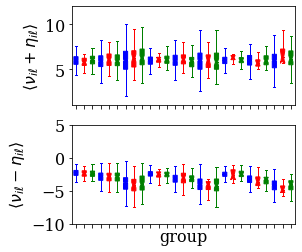

In [82]:
ns=[50]
cs=[2,2.5,3]
ds=[5,10,25]
c1='blue'
c2='red'
c3='green'


plt.subplots(2,1,figsize=(4,4))

plt.subplot(2,1,1)    
plt.ylim(1,12)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots=[]
for n in ns:
    for c in cs:
        for d in ds:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plots.append((vals[np.where(vals[:,4]==0.)[0],8]+vals[np.where(vals[:,4]==0.)[0],9])/c)
            plots.append((vals[np.where(vals[:,4]==1.)[0],8]+vals[np.where(vals[:,4]==1.)[0],9])/c)
            plots.append((vals[np.where(vals[:,4]==2.)[0],8]+vals[np.where(vals[:,4]==2.)[0],9])/c)
            
# plt.xlabel('group')
plt.xticks([])
plt.ylabel(r'$\langle \nu_{i\ell}+\eta_{i\ell} \rangle$')
box1=plt.boxplot(plots,notch=True,patch_artist=True,showfliers=False)
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][0::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][0::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)
    
plt.subplot(2,1,2)
plt.ylim(-10,5)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots=[]
for n in ns:
    for c in cs:
        for d in ds:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plots.append((vals[np.where(vals[:,4]==0.)[0],8]-vals[np.where(vals[:,4]==0.)[0],9])/c)
            plots.append((vals[np.where(vals[:,4]==1.)[0],8]-vals[np.where(vals[:,4]==1.)[0],9])/c)
            plots.append((vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c)
            
plt.xlabel('group')
plt.ylabel(r'$\langle \nu_{i\ell}-\eta_{i\ell} \rangle$')
box1=plt.boxplot(plots,notch=True,patch_artist=True,showfliers=False)
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][0::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][0::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)

plt.savefig('plots/fig4c.pdf')
plt.show()

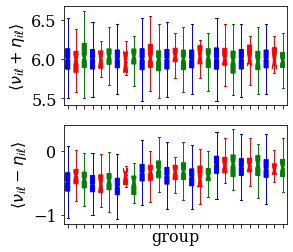

In [87]:
ns=[50]
cs=[2,2.5,3]
ds=[5,10,25]
c1='blue'
c2='red'
c3='green'


plt.subplots(2,1,figsize=(4,4))

plt.subplot(2,1,1)    
# plt.ylim(1,12)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots=[]
for n in ns:
    for d in ds:
        for c in cs:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plots.append((vals[np.where(vals[:,4]==0.)[0],6]+vals[np.where(vals[:,4]==0.)[0],7])/c)
            plots.append((vals[np.where(vals[:,4]==1.)[0],6]+vals[np.where(vals[:,4]==1.)[0],7])/c)
            plots.append((vals[np.where(vals[:,4]==2.)[0],6]+vals[np.where(vals[:,4]==2.)[0],7])/c)
            
# plt.xlabel('group')
plt.xticks([])
plt.ylabel(r'$\langle \nu_{i\ell}+\eta_{i\ell} \rangle$')
box1=plt.boxplot(plots,notch=True,patch_artist=True,showfliers=False)
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][0::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][0::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)
    
plt.subplot(2,1,2)
# plt.ylim(-10,5)
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots=[]
for n in ns:
    for d in ds:
        for c in cs:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plots.append((vals[np.where(vals[:,4]==0.)[0],6]-vals[np.where(vals[:,4]==0.)[0],7])/c)
            plots.append((vals[np.where(vals[:,4]==1.)[0],6]-vals[np.where(vals[:,4]==1.)[0],7])/c)
            plots.append((vals[np.where(vals[:,4]==2.)[0],6]-vals[np.where(vals[:,4]==2.)[0],7])/c)
            
plt.xlabel('group')
plt.ylabel(r'$\langle \nu_{i\ell}-\eta_{i\ell} \rangle$')
box1=plt.boxplot(plots,notch=True,patch_artist=True,showfliers=False)
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][0::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][0::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)

plt.savefig('plots/fig4c.pdf')
plt.show()

In [97]:
from scipy.stats import ttest_ind,pearsonr

for n in ns:
    for d in ds:
        for c in cs:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            x=vals[np.where(vals[:,4]==2.)[0],5]
            y=(vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c
            print(pearsonr(x,y))

(0.007023553559090158, 0.9398295749215291)
(0.05031621681687626, 0.6596683575935252)
(0.4774085427787028, 0.0013885822371962962)
(-0.01021271270369667, 0.9033048204107208)
(-0.0020229801519840163, 0.9846455974059817)
(-0.07887154440665113, 0.538920812984755)
(0.13433772652730494, 0.18494384253712537)
(-0.056084641418866814, 0.6785993008655892)
(-0.12374386963283965, 0.4020580215137715)


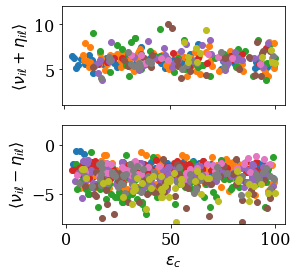

In [99]:
plt.subplots(2,1,figsize=(4,4))

plt.subplot(2,1,1)    
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plt.ylabel(r'$\langle \nu_{i\ell}+\eta_{i\ell} \rangle$')
plt.ylim(1,12)
for n in ns:
    for c in cs:
        for d in ds:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plt.scatter(vals[np.where(vals[:,4]==1.)[0],5]*100/5000, (vals[np.where(vals[:,4]==1.)[0],8]+vals[np.where(vals[:,4]==1.)[0],9])/c)

plt.subplot(2,1,2)    
# plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plt.xlabel(r'$\epsilon_c$')
plt.ylabel(r'$\langle \nu_{i\ell}-\eta_{i\ell} \rangle$')
plt.ylim(-8,2)
for n in ns:
    for c in cs:
        for d in ds:
            vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'.txt')
            plt.scatter(vals[np.where(vals[:,4]==2.)[0],5]*100/5000, (vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c)
plt.savefig('plots/fig4b.pdf')
plt.show()


### Bifurcation examples

In [26]:
n=50
nr=100
nd=5
na=0
seed=984
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)
d0=1e3
d1min=1
d1max=100
steps=5000
XD1s,XD2s,inds=rmtchem.get_drive(eta,nu,k,G,d0,d1min,d1max,steps,nd)
X0=np.exp(-G)
Xs,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1s, XD2s, output=True,stop=False)
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
XD1=XD1s[m]*(1.05)
XD2=XD2s[m]
X2,success=rmtchem.integrate(Xs[m], eta, nu, k, XD1,XD2,40,0.1,prog=True)

Integration: 100%|##############################################| Time: 0:00:16


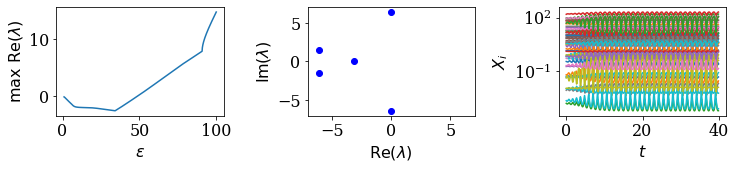

In [28]:
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)

plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.plot(d1s,np.max(np.real(evals),axis=1))

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(np.arange(0,40,0.1),X2)
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig2b.pdf')
plt.show()

saddle-node bifurcation!  3601


Integration: 100%|##############################################| Time: 0:00:01


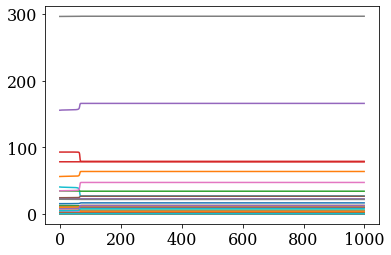

True
saddle-node bifurcation!  78


In [37]:
n=50
nr=100
nd=5
na=0
seed=999
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)
d0=1e3
d1min=1
d1max=100
steps=10000
XD1s,XD2s,inds=rmtchem.get_drive(eta,nu,k,G,d0,d1min,d1max,steps,nd)
X0=np.exp(-G)
Xs,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1s, XD2s, True)
m=len(Xs)-1
XD1=XD1s[m+1]
XD2=XD2s[m+1]
X2,success=rmtchem.integrate(Xs[-1]*(1+np.random.random(size=n)*1e-3), eta, nu, k, XD1,XD2,1000,1,prog=True)
plt.plot(X2)
plt.show()
sol=rmtchem.steady(X2[-1],eta, nu, k, XD1,XD2)
print(sol.success)
X2s,evals2,bif2=rmtchem.quasistatic(sol.x, eta, nu, k, np.flip(XD1s[:m+2],axis=0), np.flip(XD2s[:m+2],axis=0), True)
X3s,evals3,bif3=rmtchem.quasistatic(X2s[0], eta, nu, k, XD1s[m+1:], XD2s[m+1:], True)

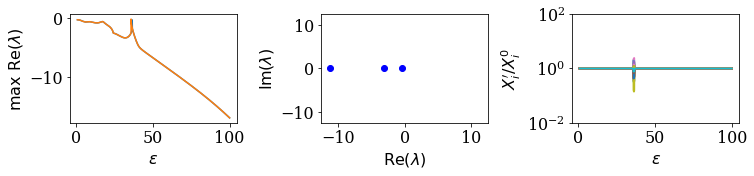

In [38]:
m2=len(X2s)-1
plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
evals4=np.zeros(steps)
evals5=np.zeros(steps)
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals4[:m+1]=np.max(np.real(evals),axis=1)
evals4[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m-m2:m+1]=np.flip(np.max(np.real(evals2),axis=1),axis=0)
evals5[:m-m2]=np.max(np.real(evals),axis=1)[:m-m2]
plt.plot(d1s,evals4)
plt.plot(d1s,evals5)

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[-2]),np.imag(evals[-2]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel(r"$X_i'/X_i^0$")
plt.xlabel('$\epsilon$')
X4s=np.zeros((steps,n))
X5s=np.zeros((steps,n))
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
X4s[:m+1]=Xs
X4s[m+1:]=X3s
X5s[m+1:]=X3s
X5s[m-m2:m+1]=np.flip(X2s,axis=0)
X5s[:m-m2]=Xs[:m-m2]
plt.yscale('log')
plt.ylim(0.01,100)
plt.plot(d1s,X5s/X4s)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig2a.pdf')
plt.show()

### Empirical reaction network stoichiometry

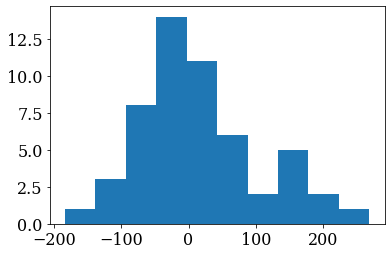

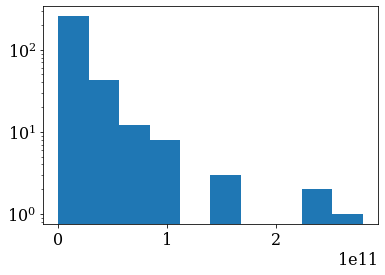

In [56]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

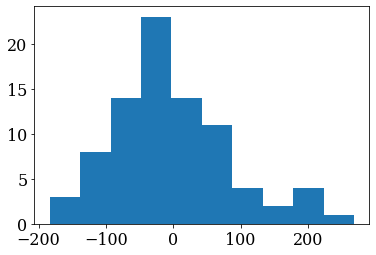

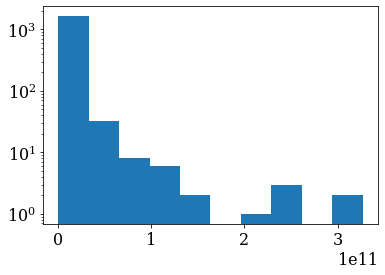

In [96]:
gas=ct.Solution('pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

### Erdos-Renyi percolation

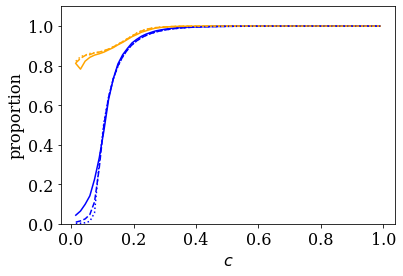

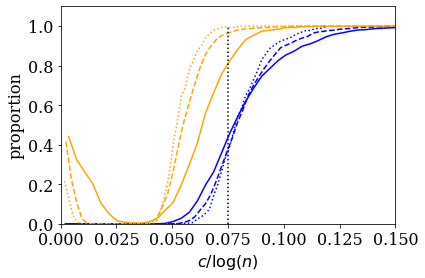